In [1]:
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm
# 반복문의 진행상황을 보여줌
# wrap any iterable with tqdm(iterable)

### mnist_resnet18 (untrained model)

In [2]:
# MNIST를 학습할 ResNet18 model (pretrained=False)

mnist_resnet18 = torchvision.models.resnet18(pretrained=False)

In [3]:
mnist_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# input channel dimension
print(mnist_resnet18.conv1.weight.shape[1])
# output channel dimension (prediction classes)
print(mnist_resnet18.fc.weight.shape[0])

3
1000


### Modifying mnist_resnet18

fully-connected layer channel: 1000 -> 10

In [5]:
MNIST_CLASS_NUM = 10

# fully-connected layer의 out_features를 1000에서 10으로 바꿈
mnist_resnet18.fc = torch.nn.Linear(in_features=512, out_features=MNIST_CLASS_NUM, bias=True)
# 새로 바뀐 fc layer를 xavier uniform으로 initialization
torch.nn.init.xavier_uniform_(mnist_resnet18.fc.weight)
stdv = 1. / math.sqrt(mnist_resnet18.fc.weight.size(1))
mnist_resnet18.fc.bias.data.uniform_(-stdv, stdv)

# input channel dimension
print(mnist_resnet18.conv1.weight.shape[1])
# output channel dimension (prediction classes)
print(mnist_resnet18.fc.weight.shape[0])

3
10


### MNIST dataset

In [6]:
mnist_train = torchvision.datasets.MNIST(root='./mnist', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='./mnist', train=False, download=True)

4


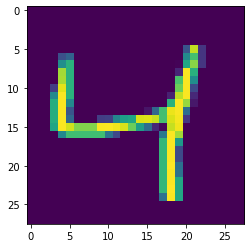

In [7]:
IMAGE_INDEX = 2
plt.imshow(mnist_train[IMAGE_INDEX][0])

print(mnist_train[IMAGE_INDEX][1])

### MNIST dataset transformed

In [8]:
# torchvision.datasets.mnist의 데이터타입은 PIL Image.
# torch.Tensor로 변경해줘야.
print(type(mnist_train[0][0]))
# 데이터는 channel이 1개 (grayscale).
# 모델은 3개.
print(np.array(mnist_train[0][0]).shape)

# grayscale의 1채널 영상을 3채널로 확장함.
# PIL Image를 torch.Tensor로 변경함.
common_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor()
])

# transform 적용
mnist_train_transformed = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=common_transform)
mnist_test_transformed = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=common_transform)

print(type(mnist_train_transformed[0][0]))
print(np.array(mnist_train_transformed[0][0]).shape)

<class 'PIL.Image.Image'>
(28, 28)
<class 'torch.Tensor'>
(3, 28, 28)


### dataloader

In [9]:
BATCH_SIZE = 64
# should be num_workers=2, but it gives warning
# num_workers=0 kills parallel computing, but gets rid of the warning
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_transformed, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

dataloaders = {'train': mnist_train_dataloader, 
               'test': mnist_test_dataloader}

### device, lr, loss_fn, optimizer

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
mnist_resnet18.to(device)

LEARNING_RATE = 0.0001

NUM_EPOCH = 5

# loss function is cross-entropy loss
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer 결정함. 모델의 파라미터와 lr 지정해줘야.
optimizer = torch.optim.Adam(mnist_resnet18.parameters(), lr=LEARNING_RATE)

cpu


### Train and test 

`model.train()`
`model.eval()`

In [11]:
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
    for phase in ['train', 'test']:
        
        running_loss = 0.
        running_acc = 0.
        
        if phase=='train':
            mnist_resnet18.train()
        elif phase=='test':
            mnist_resnet18.eval()
            
        for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):
            images = images.to(device)
            labels = labels.to(device)
            
            # initialize gradients
            optimizer.zero_grad()
            
            # train 모드일 시에는 gradient를 계산하고, 
            # 아닐 때는 gradient를 계산하지 않아 연산량 최소화
            with torch.set_grad_enabled(phase=='train'):
                
                # yhat
                logits = mnist_resnet18(images)
                
                # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 
                # 최대 output index를 찾아 예측 레이블([2])로 변경함
                # ???
                _, preds = torch.max(logits, 1)
                
                loss = loss_fn(logits, labels)
                
                if phase=='train':
                    loss.backward() # gradient 계산
                    optimizer.step() # parameter update
            
            # 한 batch에서의 loss값 저장
            running_loss += loss.item() * images.size(0)
            # 한 batch에서의 accuracy값 저장
            running_acc += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        
        print(f'Epoch: {epoch}, Phase: {phase}, Average Loss: {epoch_loss:.3f}, Average Accuracy: {epoch_acc:.3f}')
        
        if phase=='test' and best_test_accuracy < epoch_acc:
            best_test_accuracy = epoch_acc
        if phase=='test' and best_test_loss > epoch_loss:
            best_test_loss = epoch_loss
            
print(f'Best Accuracy: {best_test_accuracy}, Best Loss: {best_test_loss}')
                

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 0, Phase: train, Average Loss: 0.190, Average Accuracy: 0.941


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, Phase: test, Average Loss: 0.069, Average Accuracy: 0.978


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1, Phase: train, Average Loss: 0.057, Average Accuracy: 0.982


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1, Phase: test, Average Loss: 0.060, Average Accuracy: 0.981


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 2, Phase: train, Average Loss: 0.040, Average Accuracy: 0.987


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, Phase: test, Average Loss: 0.051, Average Accuracy: 0.984


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 3, Phase: train, Average Loss: 0.034, Average Accuracy: 0.989


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3, Phase: test, Average Loss: 0.043, Average Accuracy: 0.986


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 4, Phase: train, Average Loss: 0.028, Average Accuracy: 0.991


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, Phase: test, Average Loss: 0.041, Average Accuracy: 0.987
Best Accuracy: 0.9873999953269958, Best Loss: 0.04104293988384306


# Transfer Learning

### fashion_resnet18 (pretrained model)

In [12]:
# Fashion-MNIST를 학습할 ResNet18 model (pretrained=True)

fashion_resnet18 = torchvision.models.resnet18(pretrained=True)

In [13]:
fashion_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# input channel dimension
print(fashion_resnet18.conv1.weight.shape[1])
# output channel dimension (prediction classes)
print(fashion_resnet18.fc.weight.shape[0])

3
1000


### Modifying fashion_resnet18

In [15]:
FASHION_INPUT_NUM = 1
FASHION_CLASS_NUM = 10

# Modifying the model
fashion_resnet18.conv1 = torch.nn.Conv2d(FASHION_INPUT_NUM, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
fashion_resnet18.fc = torch.nn.Linear(in_features=512, out_features=FASHION_CLASS_NUM, bias=True)
# Initializing parameters with xavier uniform
torch.nn.init.xavier_uniform_(fashion_resnet18.fc.weight)
stdv = 1. / math.sqrt(fashion_resnet18.fc.weight.size(1))
fashion_resnet18.fc.bias.data.uniform_(-stdv, stdv)

print(fashion_resnet18.conv1.weight.shape[1])
print(fashion_resnet18.fc.weight.shape[0])

1
10


### Fashion-MNIST dataset

In [16]:
fashion_train = torchvision.datasets.FashionMNIST(root='./fashion', train=True, download=True)
fashion_test = torchvision.datasets.FashionMNIST(root='./fashion', train=False, download=True)

0


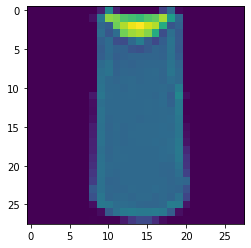

In [17]:
IMAGE_INDEX = 2 
plt.imshow(fashion_train[IMAGE_INDEX][0])

print(fashion_train[IMAGE_INDEX][1])

### Fashion-MNIST dataset transformed

In [18]:
print(type(fashion_train[0][0]))
print(np.array(fashion_train[0][0]).shape)

common_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

fashion_train_transformed = torchvision.datasets.FashionMNIST(root='./fashion', train=True, download=True, transform=common_transform)
fashion_test_transformed = torchvision.datasets.FashionMNIST(root='./fashion', train=False, download=True, transform=common_transform)

print(type(fashion_train_transformed[0][0]))

<class 'PIL.Image.Image'>
(28, 28)
<class 'torch.Tensor'>


### dataloader

In [19]:
BATCH_SIZE = 64
fashion_train_dataloader = torch.utils.data.DataLoader(fashion_train_transformed, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
fashion_test_dataloader = torch.utils.data.DataLoader(fashion_test_transformed, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

dataloaders = {"train" : fashion_train_dataloader, 
               "test" : fashion_test_dataloader}

### device, lr, loss_fn, optimizer

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)
fashion_resnet18.to(device)

LEARNING_RATE = 0.0001 

NUM_EPOCH = 5

loss_fn = torch.nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(fashion_resnet18.parameters(), lr=LEARNING_RATE) 

cpu


### Train and test

In [21]:
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
    for phase in ['train', 'test']:
        
        running_loss = 0.
        running_acc = 0.
        
        if phase=='train':
            fashion_resnet18.train()
        elif phase=='test':
            fashion_resnet18.eval()
            
        for ind, (images, labels) in enumerate(tqdm(dataloaders[phase])):
            images = images.to(device)
            labels = labels.to(device)
            
            # initialize gradients
            optimizer.zero_grad()
            
            # train 모드일 시에는 gradient를 계산하고, 
            # 아닐 때는 gradient를 계산하지 않아 연산량 최소화
            with torch.set_grad_enabled(phase=='train'):
                
                # yhat
                logits = fashion_resnet18(images)
                
                # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 
                # 최대 output index를 찾아 예측 레이블([2])로 변경함
                # ???
                _, preds = torch.max(logits, 1)
                
                loss = loss_fn(logits, labels)
                
                if phase=='train':
                    loss.backward() # gradient 계산
                    optimizer.step() # parameter update
            
            # 한 batch에서의 loss값 저장
            running_loss += loss.item() * images.size(0)
            # 한 batch에서의 accuracy값 저장
            running_acc += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        
        print(f'Epoch: {epoch}, Phase: {phase}, Average Loss: {epoch_loss:.3f}, Average Accuracy: {epoch_acc:.3f}')
        
        if phase=='test' and best_test_accuracy < epoch_acc:
            best_test_accuracy = epoch_acc
        if phase=='test' and best_test_loss > epoch_loss:
            best_test_loss = epoch_loss
            
print(f'Best Accuracy: {best_test_accuracy}, Best Loss: {best_test_loss}')
                

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 0, Phase: train, Average Loss: 0.589, Average Accuracy: 0.790


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, Phase: test, Average Loss: 0.426, Average Accuracy: 0.839


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1, Phase: train, Average Loss: 0.373, Average Accuracy: 0.862


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1, Phase: test, Average Loss: 0.348, Average Accuracy: 0.873


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 2, Phase: train, Average Loss: 0.316, Average Accuracy: 0.883


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, Phase: test, Average Loss: 0.322, Average Accuracy: 0.885


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 3, Phase: train, Average Loss: 0.276, Average Accuracy: 0.898


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3, Phase: test, Average Loss: 0.304, Average Accuracy: 0.892


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 4, Phase: train, Average Loss: 0.248, Average Accuracy: 0.908


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, Phase: test, Average Loss: 0.307, Average Accuracy: 0.890
Best Accuracy: 0.8917999863624573, Best Loss: 0.30445397114753725


# Hyperparameter Tuning